In [1]:
import os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# Path to your DEMAND NPARK folder
base_dir = "../data/DEMAND/NPARK_16k"  # adjust if needed

wav_files = sorted(
    [f for f in os.listdir(base_dir) if f.lower().endswith(".wav")]
)

print("Found", len(wav_files), "wav files")
print(wav_files[:5])

signals = []
sr = None

for fname in wav_files:
    path = os.path.join(base_dir, fname)
    x, sr_local = sf.read(path)  # x: (T,)
    if sr is None:
        sr = sr_local
    elif sr != sr_local:
        raise ValueError(f"Sampling rate mismatch in {fname}: {sr_local} vs {sr}")
    signals.append(x)

signals = np.stack(signals, axis=0)  # (n_channels, T)
n_channels, T = signals.shape
print("signals.shape:", signals.shape, "sample rate:", sr)


Found 16 wav files
['ch01.wav', 'ch02.wav', 'ch03.wav', 'ch04.wav', 'ch05.wav']
signals.shape: (16, 4800064) sample rate: 16000


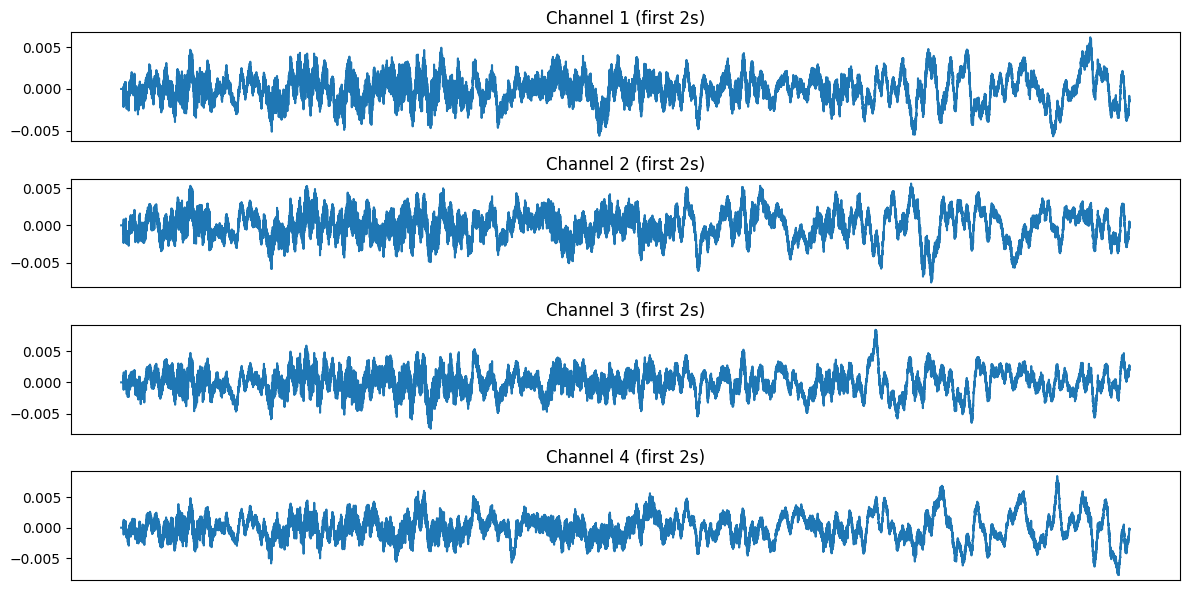

In [2]:
sec = 2
N_show = sec * sr

plt.figure(figsize=(12, 6))
for ch in range(min(4, n_channels)):
    plt.subplot(4, 1, ch+1)
    plt.plot(signals[ch, :N_show])
    plt.title(f"Channel {ch+1} (first {sec}s)")
    plt.xticks([])
plt.tight_layout()
plt.show()

In [3]:
duration_sec = 10
N = min(T, duration_sec * sr)

X_raw = signals[:, :N]     # (16, N)

# Center each channel (zero mean)
X_centered = X_raw - X_raw.mean(axis=1, keepdims=True)

print("Working with shape:", X_centered.shape)

Working with shape: (16, 160000)


In [4]:
X = X_centered.T  # (N, 16)
print("X shape for sklearn:", X.shape)

X shape for sklearn: (160000, 16)


In [5]:
from sklearn.decomposition import FastICA

n_components = n_channels  # 16
ica = FastICA(
    n_components=n_components,
    whiten='unit-variance',
    max_iter=500,
    random_state=0
)

S_hat = ica.fit_transform(X)    # shape (N, n_components)
A_est = ica.mixing_             # estimated mixing matrix
print("S_hat shape:", S_hat.shape)
print("A_est shape:", A_est.shape)

S_hat shape: (160000, 16)
A_est shape: (16, 16)


In [6]:
S_hat_T = S_hat.T   # (n_components, N)

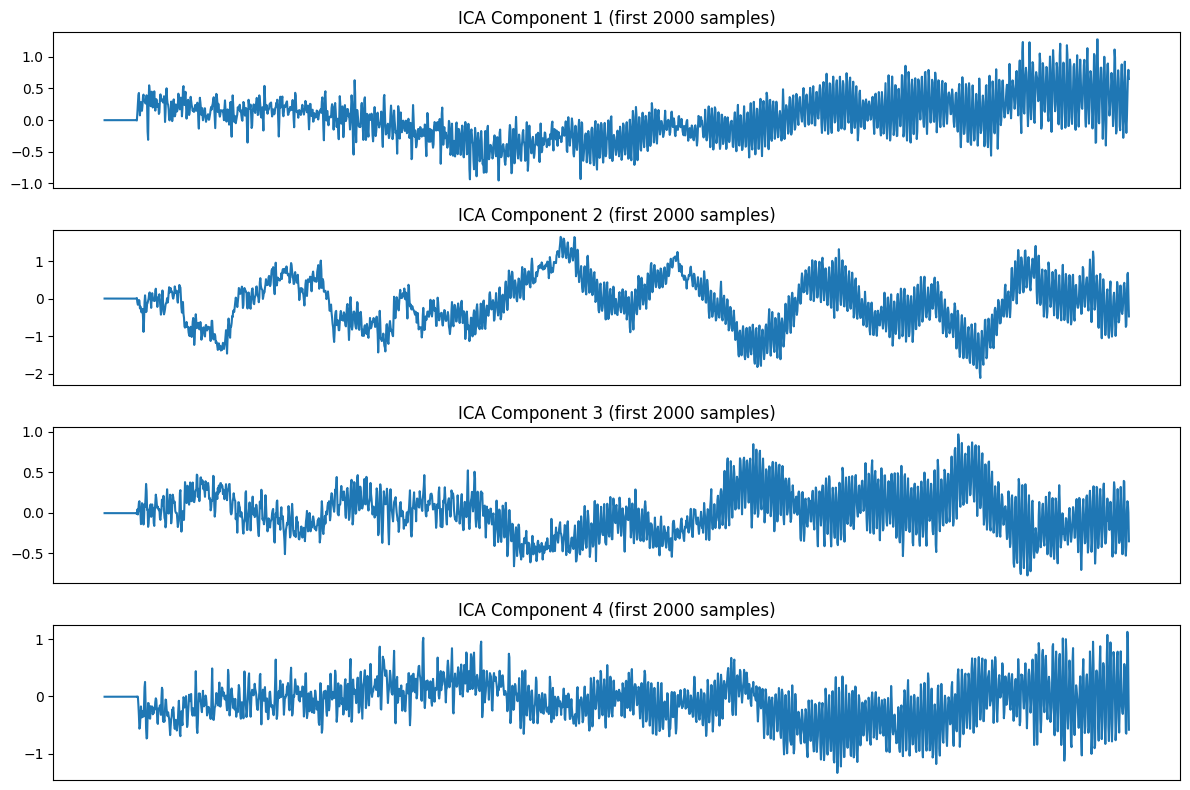

In [7]:
n_plot = 4  # number of components to show

plt.figure(figsize=(12, 8))
for i in range(n_plot):
    plt.subplot(n_plot, 1, i+1)
    plt.plot(S_hat_T[i, :2000])
    plt.title(f"ICA Component {i+1} (first 2000 samples)")
    plt.xticks([])
plt.tight_layout()
plt.show()


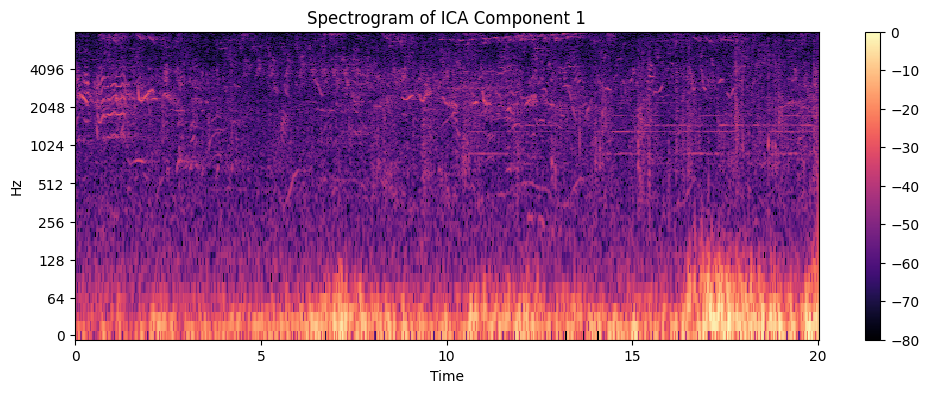

In [8]:
import librosa
import librosa.display

comp_idx = 0  # change 0,1,2,... to inspect others

comp = S_hat_T[comp_idx]
D = librosa.amplitude_to_db(
    np.abs(librosa.stft(comp, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of ICA Component {comp_idx+1}")
plt.colorbar()
plt.show()


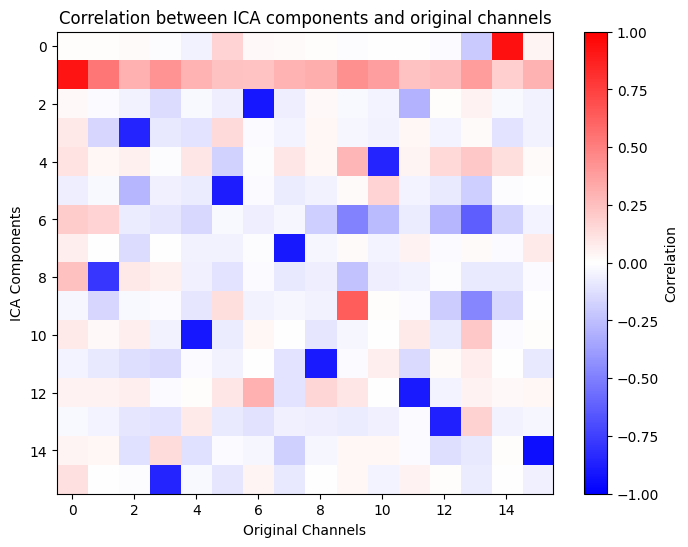

In [9]:
# Correlation between components and original channels (10s segment)
corr = np.corrcoef(S_hat_T, X_centered)  # matrix of size (16+16, 16+16)

# Extract block: components vs channels
comp_vs_chan = corr[:n_components, n_components:]

plt.figure(figsize=(8, 6))
plt.imshow(comp_vs_chan, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xlabel("Original Channels")
plt.ylabel("ICA Components")
plt.title("Correlation between ICA components and original channels")
plt.show()

In [10]:
from IPython.display import Audio

def play_ic(i):
    print(f"Playing ICA component {i}")
    return Audio(S_hat_T[i], rate=sr)

# Example usage:
play_ic(4)   # try others: play_ic(1), play_ic(2), ...


Playing ICA component 4


In [11]:
def play_channel(ch):
    print(f"Playing raw channel {ch}")
    return Audio(X_centered[ch], rate=sr)

# Example:
play_channel(0)

Playing raw channel 0


In [12]:
!pip install pyroomacoustics

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\simor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
import numpy as np

# Reuse from Phase 2A (adjust if your variable names differ)
# signals.shape == (16, T)
n_channels, T = signals.shape
print("signals:", signals.shape, "sr:", sr)

duration_sec = 10
N = min(T, duration_sec * sr)

# Use first 4 microphones for now
n_mics = 4
X_raw = signals[:n_mics, :N]              # (4, N)

# Center each channel
X_centered = X_raw - X_raw.mean(axis=1, keepdims=True)

print("X_centered shape:", X_centered.shape)

# audio for BSS: shape (N, n_mics)
audio = X_centered.T    # (N, 4)
print("audio shape:", audio.shape)


signals: (16, 4800064) sr: 16000
X_centered shape: (4, 160000)
audio shape: (160000, 4)


In [14]:
import pyroomacoustics as pra
import librosa

print("audio shape:", audio.shape)  # (N, n_mics)

# STFT parameters
fft_size = 2048
hop = fft_size // 2
window = "hann"  # librosa will create the Hann window internally

# 1) STFT per channel with librosa
# We want X_stft: (n_frames, n_freqs, n_mics)
stft_list = []

for ch in range(n_mics):
    # librosa.stft returns (n_freqs, n_frames)
    S = librosa.stft(audio[:, ch],
                     n_fft=fft_size,
                     hop_length=hop,
                     window=window)
    stft_list.append(S.T)  # (n_frames, n_freqs)

# Stack into (n_frames, n_freqs, n_mics)
X_stft = np.stack(stft_list, axis=-1)
print("X_stft shape (frames, freqs, mics):", X_stft.shape)

# 2) AuxIVA BSS
n_src = n_mics  # determined case
Y = pra.bss.auxiva(X_stft, n_src=n_src, n_iter=20)
print("Y shape (frames, freqs, sources):", Y.shape)

# 3) iSTFT for each separated source (librosa)
sep_signals = []
n_frames, n_freqs, n_src = Y.shape

for i in range(n_src):
    # Y[:, :, i]: (n_frames, n_freqs) -> (n_freqs, n_frames) for librosa
    Y_i = Y[:, :, i].T
    y_i = librosa.istft(Y_i,
                        hop_length=hop,
                        window=window)
    sep_signals.append(y_i)

# Stack and equalize length
min_len = min(len(y) for y in sep_signals)
sep_signals = np.stack([y[:min_len] for y in sep_signals], axis=-1)  # (T, n_src)

print("Separated time-domain shape:", sep_signals.shape)

audio shape: (160000, 4)
X_stft shape (frames, freqs, mics): (157, 1025, 4)
Y shape (frames, freqs, sources): (157, 1025, 4)
Separated time-domain shape: (159744, 4)


In [15]:
from IPython.display import Audio

def play_sep(i):
    print(f"Playing separated source {i}")
    return Audio(sep_signals[:, i], rate=sr)

def play_mic(i):
    print(f"Playing raw mic {i}")
    return Audio(audio[:, i], rate=sr)

# Examples:
# First listen to a raw mic:
play_mic(0)

# Then listen to separated sources:
# play_sep(0)
# play_sep(1)
# play_sep(2)
# play_sep(3)

Playing raw mic 0


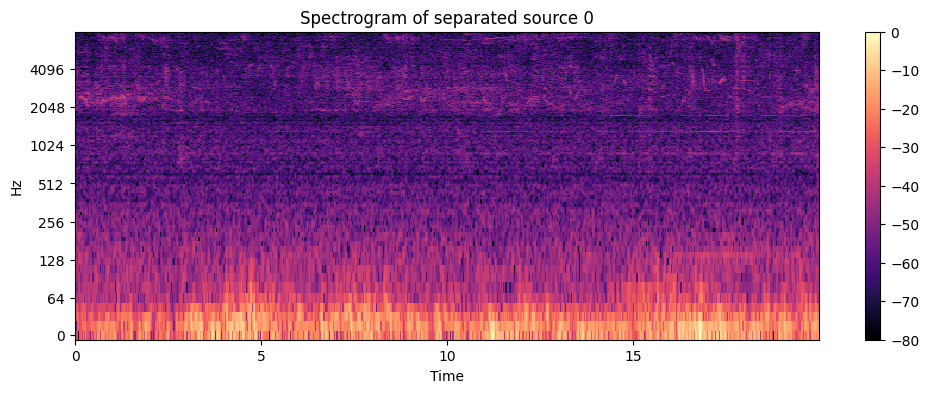

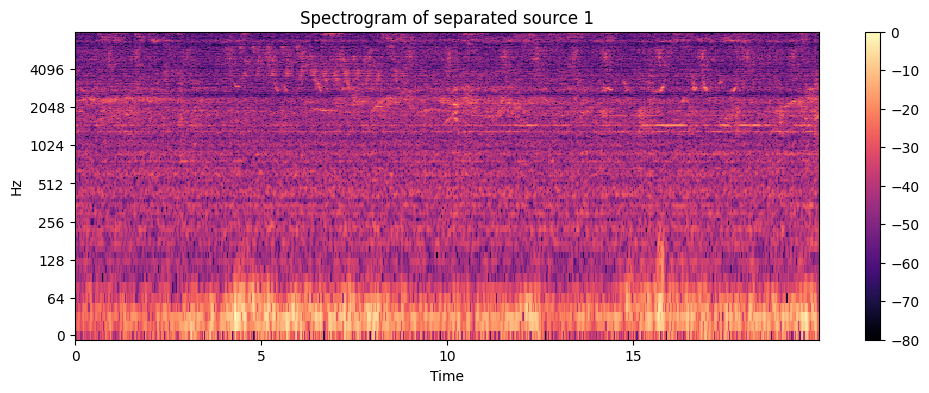

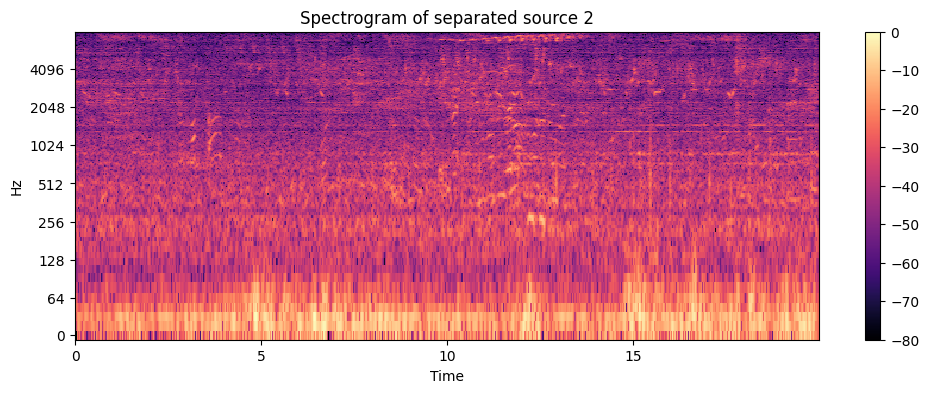

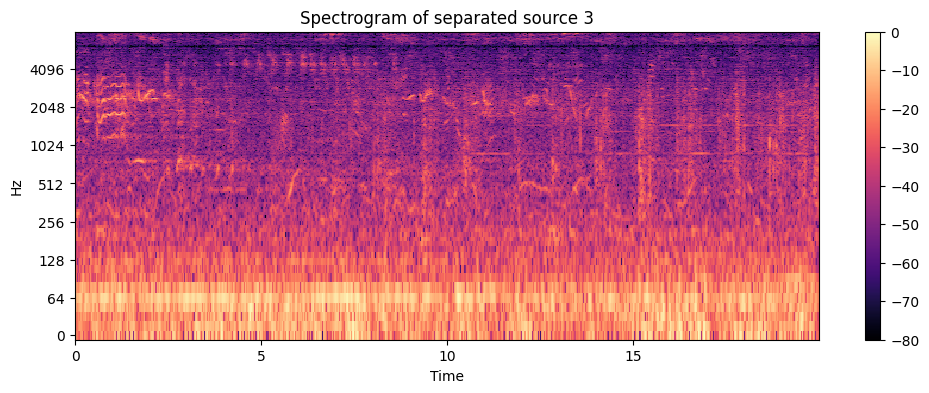

In [16]:
import librosa.display
import matplotlib.pyplot as plt

src_idx = 0   # change 0..3 to inspect others
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated source {src_idx}")
plt.colorbar()
plt.show()


src_idx = 1   # change 0..3 to inspect others
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated source {src_idx}")
plt.colorbar()
plt.show()


src_idx = 2   # change 0..3 to inspect others
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated source {src_idx}")
plt.colorbar()
plt.show()

src_idx = 3   # change 0..3 to inspect others
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated source {src_idx}")
plt.colorbar()
plt.show()
